Develop a system for plagiarism detection: you are given a set of textual documents and you<br>are asked to detect which documents contain significant overlapping in content. It is up to you to<br>define what "significant" and "overlapping" mean. You can also use examples of plagiarized<br>portions of documents.

# Retrieving data

Let us now retrieve the data by developing a script that can download around 100 papers from arXiv website. <br>
The file arXiv.csv is a collection of 24000+ paper from arXiv website meta data published between 1992 to 2017. <br>
This file was downloaded from Kaggle - https://www.kaggle.com/neelshah18/arxivdataset.

In [1]:
def get_list_of_papers(fetch_count):
    papers_url = []
    count = 0
    for line in open('arxiv_data.csv', 'r'):
        if count == fetch_count:
            break
        line = line.strip()
        try:
            topic = line[:line.index(',')][:7]
            # Let us download papers whose topic starts with Machine or Neural
            if topic == 'Machine' or topic == 'Neural ':
                line = line[line.index('http://'):]
                line = line[:line.index(',')]
                papers_url.append(line)
                count += 1
        except:
            continue
    return papers_url
papers = get_list_of_papers(100)

In [2]:
def file_path_exists(filepath):
    if not os.path.exists(os.path.dirname(filepath)):
        try:
            os.makedirs(os.path.dirname(filepath))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                return False
    return True

In [3]:
# Download all the files in papers list
import urllib2
import os
from tqdm import tqdm

def download_file(download_url):
    response = urllib2.urlopen(download_url)
    download_filename = './ArXiv_Papers/'+download_url[download_url.rfind('/')+1:]
    if file_path_exists(download_filename):
        file = open(download_filename, 'w')
        file.write(response.read())
        file.close()
    else:
        print 'Unable to create filepath' + download_filename
    
for file in tqdm(papers):
    download_file(file)

In [4]:
# Let us now extract the text from pdf documents and create a folder cosisting of .txt files of the papers
import pdfminer

from cStringIO import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import sys, getopt

#converts pdf, returns its text content as a string
def convert(file_name, pages=None):
    if not pages:
        page_nums = set()
    else:
        page_nums = set(pages)
    output = StringIO()
    manager = PDFResourceManager()
    converter = TextConverter(manager, output, laparams=LAParams())
    interpreter = PDFPageInterpreter(manager, converter)
    in_file = open(file_name, 'rb')
    for page in PDFPage.get_pages(in_file, page_nums):
        interpreter.process_page(page)
    in_file.close()
    converter.close()
    text = output.getvalue()
    output.close
    return text 

def convertMultiple(pdf_dir, txt_dir):
    if pdf_dir == "": pdf_dir = os.getcwd() + "\\"
    for pdf in tqdm(os.listdir(pdf_dir)): 
        pdf_filename = pdf_dir + pdf 
        try:
            text = convert(pdf_filename)
            text_filename = txt_dir + pdf + ".txt"
            if file_path_exists(text_filename):
                text_file = open(text_filename, "w") 
                text_file.write(text)
            else:
                'Unable to create filepath' + text_filename
        except:
            print 'Unable to convert file ' + pdf
            continue

pdf_dir = "./ArXiv_Papers/"
txt_dir = "./ArXiv_Papers_txt/"
convertMultiple(pdf_dir, txt_dir)

# Data preprocessing

Let us now preprocess the data by removing unwanted characters and applying Lemmatization.

In [5]:
import re
def document_list(dir_name):
    documents = []
    for file in tqdm(os.listdir(dir_name)):
        # Ignore hidden files
        if not file.startswith('.'):
            with open(dir_name + file, 'r') as f:
                data = f.read().replace('\n', ' ').strip()
                data = re.sub(' +',' ',data)
                data = re.sub(r'[^\x00-\xff]', '', data)
                data = data.replace('\d', ' ').strip()
                data = data.replace('.', '. ')
                data = ''.join([c for c in data if ord(c) < 128])
                documents.append(data)
    return documents
documents = document_list('./ArXiv_Papers_txt/')

100%|██████████| 101/101 [00:00<00:00, 129.00it/s]


We can spend more time in this phase to clean the data well. Since this is not the goal of the assignment let us continue for now.

In [6]:
# Remove punctuations and lemmatize every word
import nltk, string
nltk.download('wordnet') # first-time use only
lemma = nltk.stem.WordNetLemmatizer()

# Lemmatize each word
def lemma_words(words):
    return [lemma.lemmatize(word) for word in words]

punctuations = dict((ord(punctuation), None) for punctuation in string.punctuation)

# Normalize by removing the case and punctuations
def lemmatize(document):
    return lemma_words(nltk.word_tokenize(document.lower().translate(punctuations)))

[nltk_data] Downloading package wordnet to /Users/vasisht/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Vectorize the documents using tf-idf vectorizer removing the stop words
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vector = TfidfVectorizer(tokenizer=lemmatize, stop_words='english')
tf_idf = tf_idf_vector.fit_transform(documents)
vocabulary_lookup = {v:k for k,v in tf_idf_vector.vocabulary_.items()}

# Data Visualization

In [8]:
print 'The number of words in the vocabulary is ' + str(tf_idf.shape[1])

The number of words in the vocabulary is 31647


In [9]:
# Get number of unique words, highest tf idf scores and corresponding words per document
from scipy.sparse import csr_matrix
import numpy as np
unique_words = []
tf_idf_score = []
tf_idf_score_vocabulary = []
for x in range(len(papers)):
    unique_words.append(csr_matrix.getnnz(tf_idf[x]))
    tf_idf_score.append(np.max(tf_idf[x]))
    tf_idf_score_vocabulary.append(vocabulary_lookup[np.argmax(tf_idf[x])])

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15

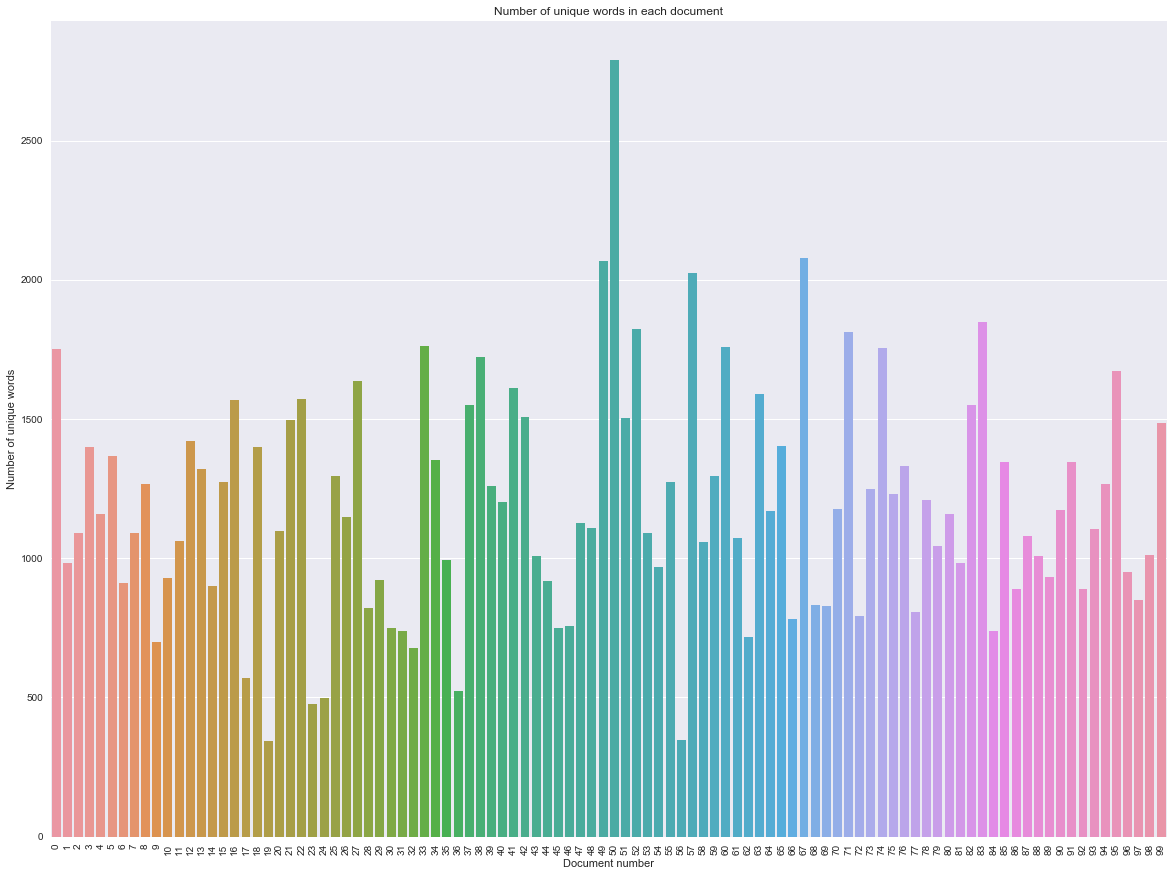

In [11]:
sns.barplot(x=[x for x in range(len(unique_words))], y=unique_words)
plt.title('Number of unique words in each document')
plt.ylabel('Number of unique words')
plt.xlabel('Document number')
plt.xticks(rotation=90)
plt.show()

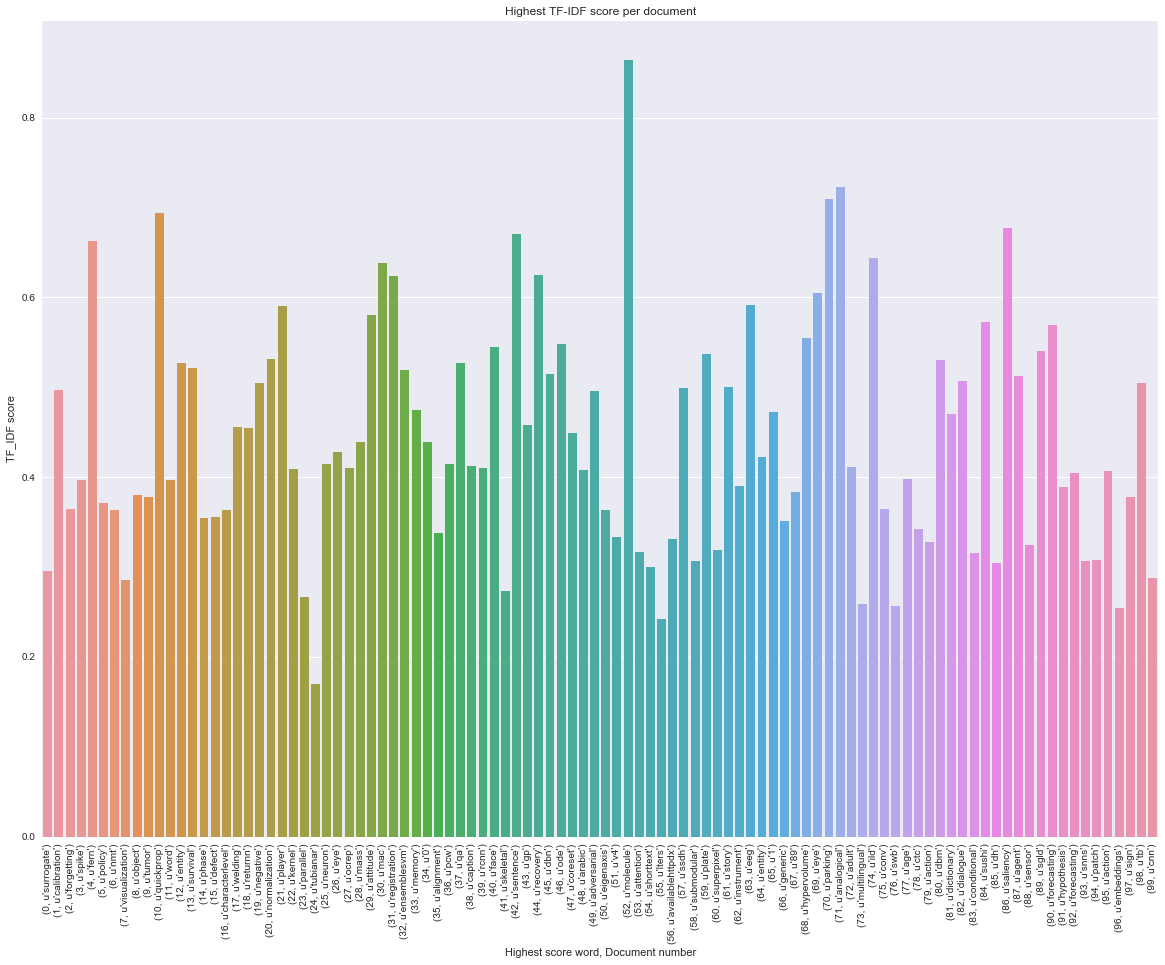

In [12]:
sns.barplot(x=[str((s, d)) for s, d in enumerate(tf_idf_score_vocabulary)], y=tf_idf_score)
plt.title('Highest TF-IDF score per document')
plt.ylabel('TF_IDF score')
plt.xlabel('Highest score word, Document number')
plt.xticks(rotation=90)
plt.show()

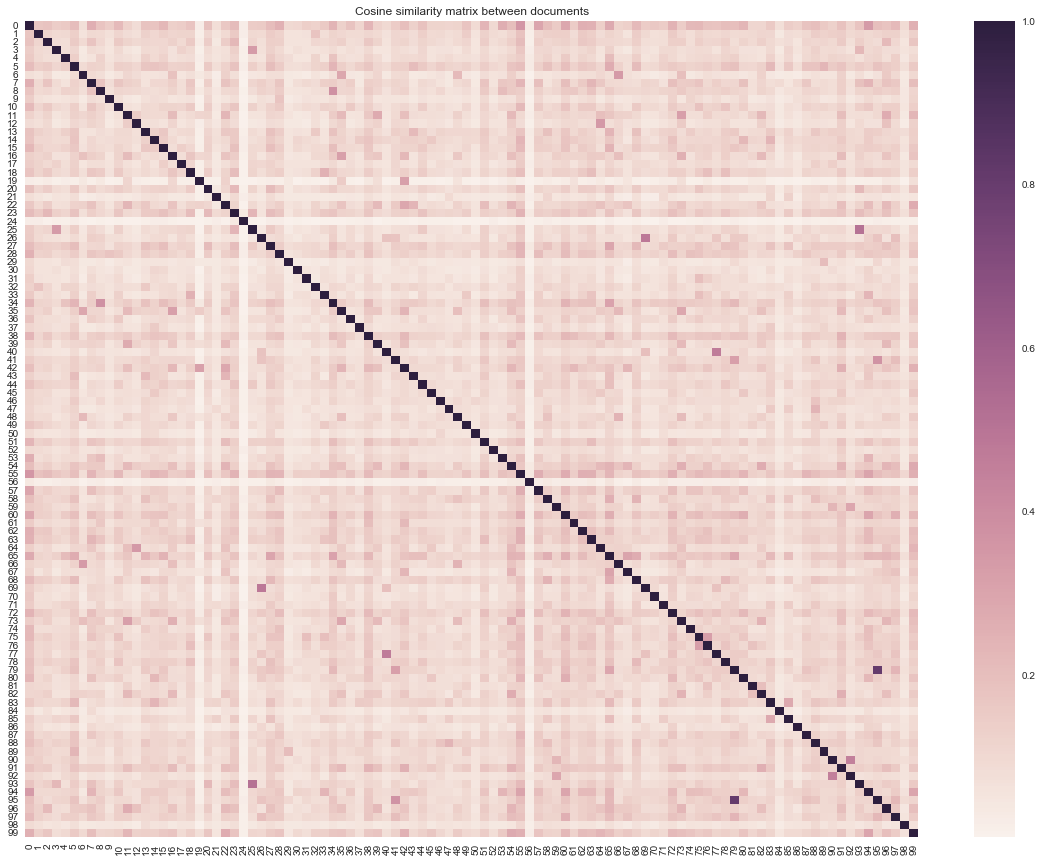

In [13]:
# Let us now plot the cosine similarity between documents
cos_similarity_matrix = (tf_idf * tf_idf.T).toarray()
sns.heatmap(cos_similarity_matrix)
plt.title('Cosine similarity matrix between documents')
plt.show()

By just this simple method we find that there are a few pairs of documents (dark colored) that are similar. Also we see that there is something wierd with documents 19, 24 and 56 (On further investigating I realized that it is due to parsing error from pdf to text). Since the goal of the challenge is to find similar documents let us ignore this for now and continue.

In [15]:
# Get most similiar document
most_similar_cos_similarity = []
for x in cos_similarity_matrix:
    most_similar_cos_similarity.append(np.argsort(x)[::-1][1])

# Model building

Let us now build a Doc2Vec model

In [16]:
# Let us tag the documents
import gensim
from nltk.corpus import stopwords
# Convert all rows of our info data to tagged document
def tag_docs(documents):
    tagged_docs = []
    for rn, d in enumerate(documents):
        row = d.lower()
        words = gensim.utils.simple_preprocess(row)
        # Remove stopwords
        words = [word for word in words if word not in stopwords.words('english')]
        words = lemma_words(words)
        tagged_docs.append(gensim.models.doc2vec.TaggedDocument(words, [rn]))
    return tagged_docs
tagged_docs = tag_docs(documents)

Using TensorFlow backend.


In [17]:
# Build a model to convert the document to vector
# The hyperparameters here can be further tuned to get a better model
model = gensim.models.doc2vec.Doc2Vec(size=25, min_count=5, window=10, workers=4, alpha=0.025)

In [18]:
# Build the vocabulary using the tagged documents
model.build_vocab(tagged_docs)

In [19]:
'''
Calculate accuracy of the model by infering the vector with the current model, getting the most similiar documents
and checking where the current model ranks when finding the most similiar documents. If the document itself is retrieved
as the most similiar document ranking number 1, we count it as accurate and not accurate if it comes in any other rank.
'''
import collections

def model_accuracy():
    ranks = []
    for doc_id in range(len(tagged_docs)):
        inferred_vector = model.infer_vector(tagged_docs[doc_id].words)
        sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
        rank = [docid for docid, sim in sims].index(doc_id)
        ranks.append(rank)
    c = collections.Counter(ranks)
    return c, float(c[0])/float(len(tagged_docs))

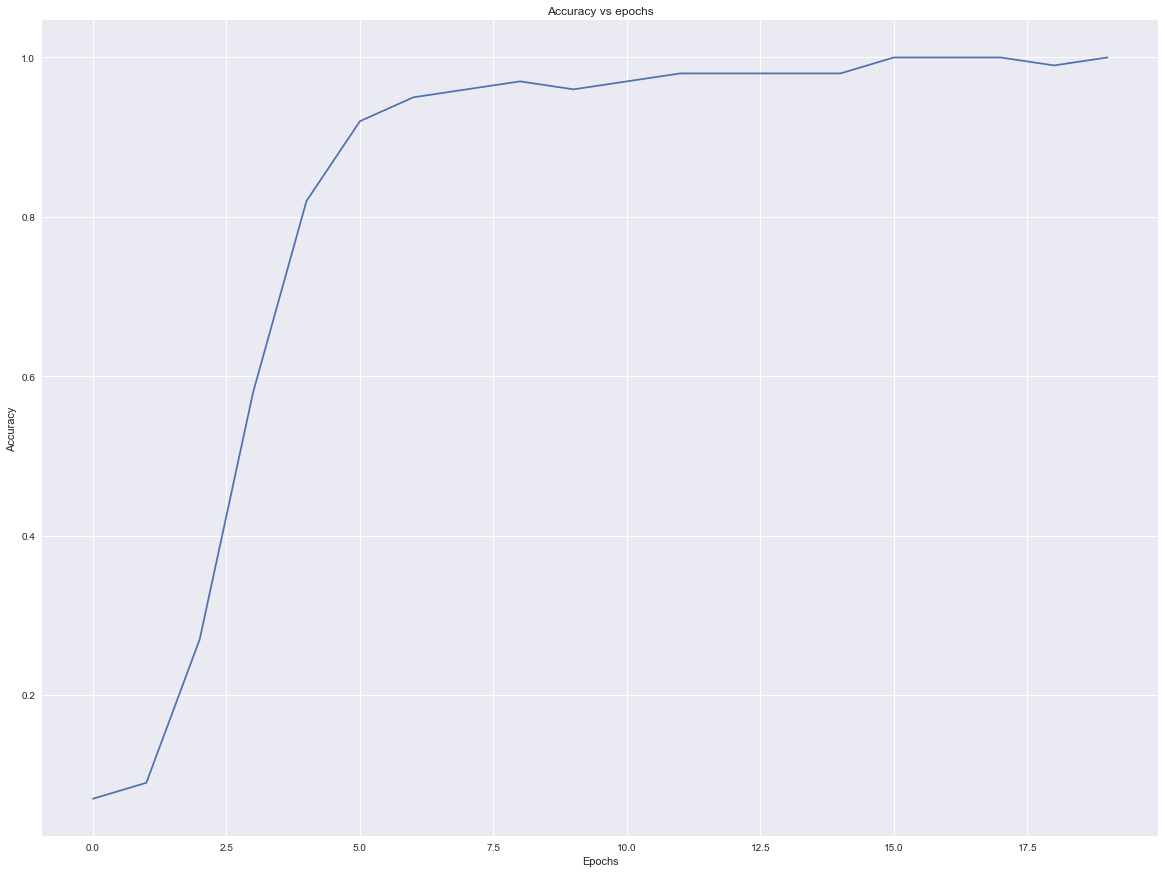

In [20]:
# Train the model and plot accuracy vs epoch curve
NUM_OF_EPOCHS = 20
acc = []
for _ in range(NUM_OF_EPOCHS):
    model.train(tagged_docs, total_examples=model.corpus_count, epochs=1)
    ranks, accuracy = model_accuracy()
    acc.append(accuracy)
    
plt.plot(acc)
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

We get a very good accuracy in just a short time, mostly because we have less data

In [21]:
# Get similiar documents
most_similar = []
for doc_id in range(len(tagged_docs)):
    inferred_vector = model.infer_vector(tagged_docs[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=2)
    if sims[0][0] == doc_id:
        most_similar.append(sims[1][0])
    else:
        most_similar.append(sims[0][0])

We see a lot of commonalities between the above similarities and the heat map we plotted earlier.

In [22]:
# Now we can check for consensus from both sides
# If document a is similar to b, is b also similar to a
def consensus(l):
    sim_dict = {}
    for x in range(len(l)):
        sim = l[x]
        if l[sim] == x:
            if sim in sim_dict or x in sim_dict:
                continue
            else:
                sim_dict[x] = sim
    return sim_dict
    
cosine_similarity_consesus = consensus(most_similar_cos_similarity)
doc2vec_consensus = consensus(most_similar)

In [23]:
# Check for consensus from both cosine similarity and Doc2Vec
reverse_doc2vec_consensus = {(v,k) for (k, v) in doc2vec_consensus.items()}
for key in cosine_similarity_consesus.keys():
    if key in doc2vec_consensus and (cosine_similarity_consesus[key] == doc2vec_consensus[key]):
        print 'Document ' + str(key) + ' is most similar to ' + str(doc2vec_consensus[key])
    elif key in reverse_doc2vec_consensus and (cosine_similarity_consesus[key] == reverse_doc2vec_consensus[key]):
        print 'Document ' + str(key) + ' is most similar to ' + str(reverse_doc2vec_consensus[key])

Document 83 is most similar to 85
Document 6 is most similar to 66
Document 8 is most similar to 34
Document 40 is most similar to 77
Document 25 is most similar to 93
Document 26 is most similar to 69
Document 79 is most similar to 95
Document 90 is most similar to 92


By thresholding both cosine similarity as well as Doc2Vec we can zero down on the most similar documents. Also on checking the above pair of documents you can see why the model thinks they are similar, since they talk about the similar topic.

Since this is an unsupervised task, the best way to assess the system is for a human to check if the most similar results shown are indeed true. Further we can make this a supervised task by asking people to rate the degree to which the documents are similar and training a new model.

Malicious authors can trick the system by talking about the same topic but using a different set of vocabulary. The model only sees whatever it has learnt in its vocabulary and does not recognize others.

This system can be scaled to multiple documents by using distributed technology. Most of the libraries used work on a distributed setting as well.

We can further improve by implementing the following paper:

Hua He, Kevin Gimpel, and Jimmy Lin. Multi-Perspective Sentence Similarity Modeling with Convolutional Neural Networks - http://aclweb.org/anthology/D/D15/D15-1181.pdf

In this notebook we have seen how to download files from the internet, convert them to text, convert the text to vectors and check for similarity between the documents. 

Thanks to Yewno for providing me this challenge.

Position: Data Scientist

By: VASISHT RAGHAVENDRA